In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
from sparix.modeling.transformer import Transformer

In [3]:
import h5py
import math
import random
import os

In [4]:
import matplotlib.pyplot       as plt
import matplotlib.colors       as mcolors
import matplotlib.patches      as mpatches
import matplotlib.transforms   as mtransforms
import matplotlib.font_manager as font_manager
%matplotlib inline

In [5]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [6]:
path_h5 = "3IYF.Fibonacci.h5"
fh = h5py.File(path_h5, "r")
frame_source = fh["intensities"]
frame_source.shape

(5000, 1, 156, 156)

In [7]:
# Figure out the padding
N, C, H, W = frame_source.shape
H_patch = 16
W_patch = 16
H_patch_count = math.ceil(H / H_patch)
W_patch_count = math.ceil(W / W_patch)
H_padded = H_patch_count * H_patch
W_padded = W_patch_count * W_patch

In [8]:
tok_size            = H_patch * W_patch
embd_size           = 768    # For using a pre-trained model from google
num_frame_in_context = 4
context_length      = num_frame_in_context * H_patch_count * W_patch_count
num_blocks          = 4
num_heads           = 4
uses_causal_mask    = True
attention_dropout   = 0.1
residual_dropout    = 0.1
feedforward_dropout = 0.1
model = Transformer(tok_size            = tok_size,
                    embd_size           = embd_size,
                    context_length      = context_length,
                    num_blocks          = num_blocks,
                    num_heads           = num_heads,
                    uses_causal_mask    = uses_causal_mask,
                    attention_dropout   = attention_dropout,
                    residual_dropout    = residual_dropout,
                    feedforward_dropout = feedforward_dropout,)
model.to(device)

Transformer(
  (tok_embd_layer): Linear(in_features=256, out_features=768, bias=True)
  (pos_embd_layer): Embedding(400, 768)
  (transformer_block): Sequential(
    (0): TransformerBlock(
      (multi_head_att_layer): MultiHeadAttention(
        (proj_q): Linear(in_features=768, out_features=768, bias=True)
        (proj_k): Linear(in_features=768, out_features=768, bias=True)
        (proj_v): Linear(in_features=768, out_features=768, bias=True)
        (proj_linear): Linear(in_features=768, out_features=768, bias=True)
        (attention_dropout): Dropout(p=0.1, inplace=False)
        (residual_dropout): Dropout(p=0.1, inplace=False)
      )
      (ff_layer): FeedForward(
        (ff_layer): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
          (3): Dropout(p=0.1, inplace=False)
        )
      )
      (layer_norm_pre_multi_head): LayerNorm((768,), eps=1e-05

In [9]:
print(sum(p.numel() for p in model.parameters())/1e6, 'M parameters')

29.054464 M parameters


In [10]:
# [[[ USER INPUT ]]]
timestamp_prev = "2023_0903_1745_28"
epoch          = 1363

drc_chkpt = "chkpts"
fl_chkpt_prev   = None if timestamp_prev is None else f"{timestamp_prev}.epoch_{epoch}.chkpt"
path_chkpt_prev = None if fl_chkpt_prev is None else os.path.join(drc_chkpt, fl_chkpt_prev)

chkpt = torch.load(path_chkpt_prev)

# Load weights...
model.module.load_state_dict(chkpt['model_state_dict']) if hasattr(model, 'module') else \
model.load_state_dict(chkpt['model_state_dict'])

<All keys matched successfully>

In [32]:
seed = 7
random.seed(seed)
torch.manual_seed(seed)

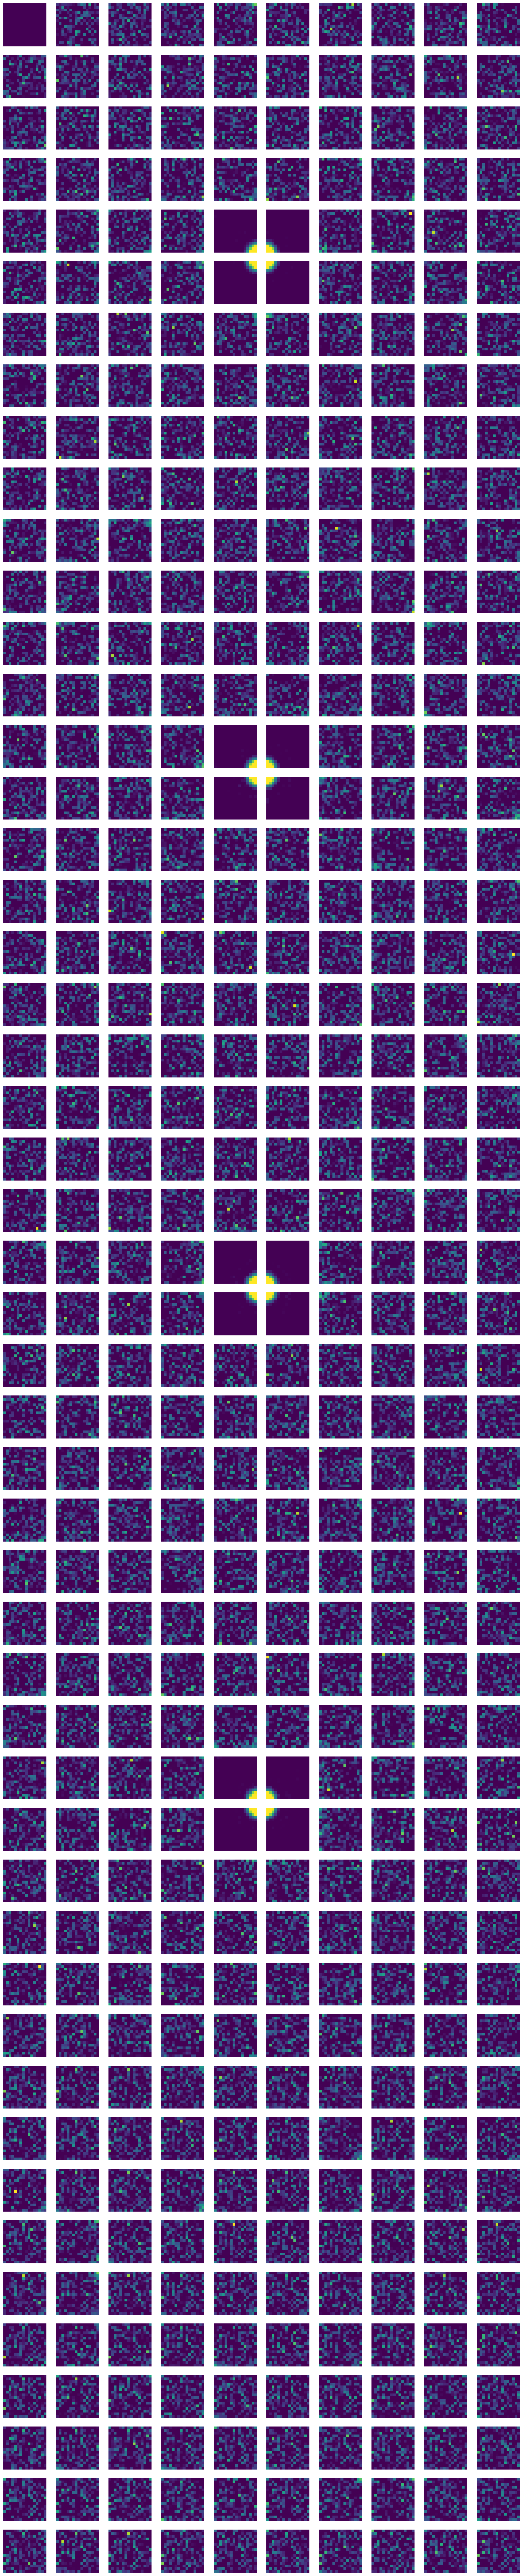

In [47]:
input = torch.zeros(1, 1, H_patch * W_patch).to(device)
input = input[:, -context_length:]

ncols = 10
nrows = 10 * 5
fig   = plt.figure(figsize = (20,20 * 5))
gspec = fig.add_gridspec( nrows, ncols, )

ax_list = [ fig.add_subplot(gspec[i, j], aspect = 1) for i in range(nrows) for j in range(ncols)]

ax = ax_list[0]
data_viz = input.view(H_patch, W_patch).cpu().numpy()
vmin = data_viz.mean()
vmax = data_viz.mean() + 4 * data_viz.std()
ax.imshow(data_viz, vmin = vmin, vmax = vmax)
ax.set_xticks([])
ax.set_yticks([])

# Hide the frame box
ax.spines['top'   ].set_visible(False)
ax.spines['right' ].set_visible(False)
ax.spines['left'  ].set_visible(False)
ax.spines['bottom'].set_visible(False)

prediction_length = ncols * nrows - 1
for idx in range(prediction_length):
    next_patch = model.generate_one(input[:,-context_length:])

    ax = ax_list[idx+1]
    data_viz = next_patch.view(H_patch, W_patch).cpu().numpy()
    vmin = data_viz.mean()
    vmax = data_viz.mean() + 4 * data_viz.std()
    ax.imshow(data_viz, vmin = vmin, vmax = vmax)
    ax.set_xticks([])
    ax.set_yticks([])

    # Hide the frame box
    ax.spines['top'   ].set_visible(False)
    ax.spines['right' ].set_visible(False)
    ax.spines['left'  ].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    input = torch.cat([input, next_patch], dim = 1)


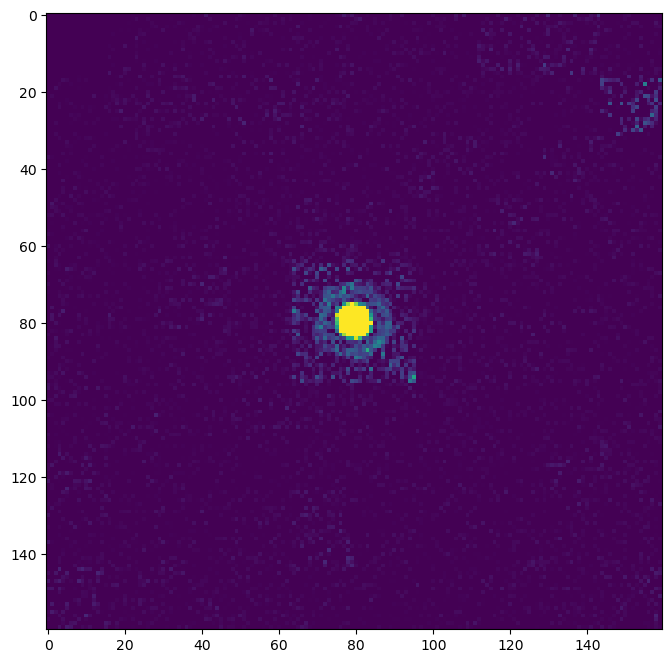

In [39]:
idx = 0
patch_count = H_patch_count * W_patch_count
data_viz = input[0, idx * patch_count : (1 + idx) * patch_count].view(patch_count, H_patch, W_patch).view(H_patch_count, W_patch_count, H_patch, W_patch)
data_viz = data_viz.transpose(1, 2).contiguous().view(H_patch_count * H_patch, W_patch_count * W_patch).cpu().numpy()

fig = plt.figure(figsize = (8, 8))
vmin = data_viz.mean()
vmax = data_viz.mean() + 4 * data_viz.std()
plt.imshow(data_viz, vmin = vmin, vmax = vmax)

In [41]:
data_viz = frame_source[0][0]

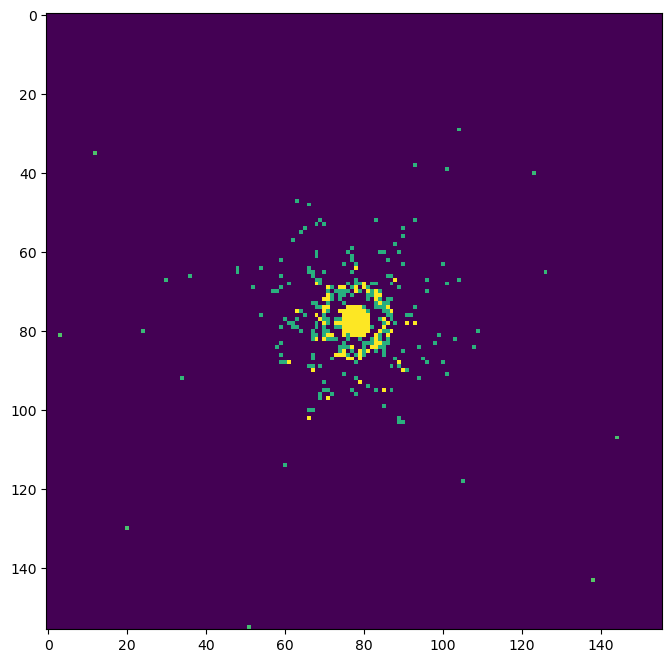

In [43]:
idx = 0

fig = plt.figure(figsize = (8, 8))
vmin = data_viz.mean()
vmax = data_viz.mean() + 4 * data_viz.std()
plt.imshow(data_viz, vmin = vmin, vmax = vmax)